In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from sklearn.metrics import mean_squared_error

In [2]:
GOOGL = pd.read_csv('GOOGL.csv')

### Model 2. Moving Average
Moving Average is a very simple model for Time Series modelling.

$MA = \frac{A_1 + A_2 + \cdots + A_n}{n}$

where:

$A = $ Average in period $n$

$n = $ Number of time periods 

In [3]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

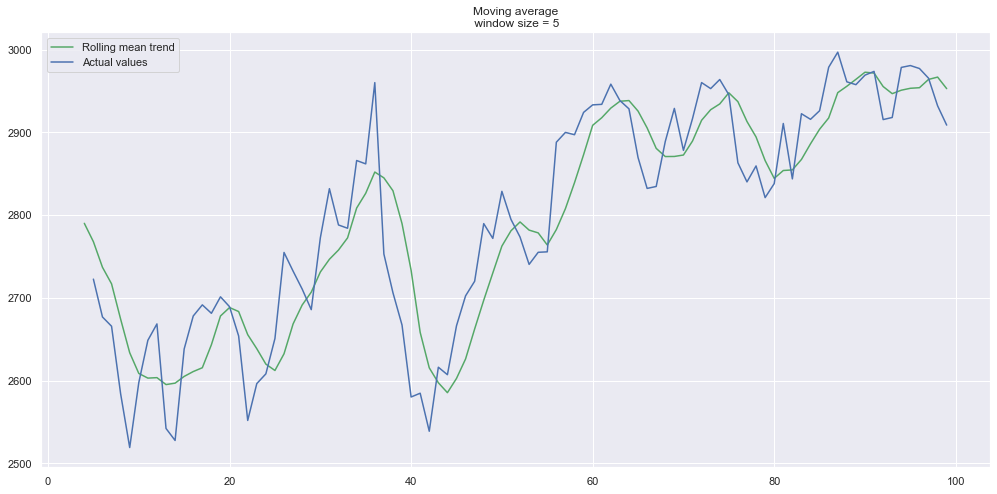

In [4]:
#Smooth by the previous 5 days (by week)
plot_moving_average(GOOGL['4. close'], 5)

In [94]:
GOOGL['4. close'].rolling(window=5).mean().isnull().sum()

4

In [64]:
mean_squared_error(
    GOOGL['4. close'].rolling(window=5).mean()[-96:], 
    GOOGL['4. close'][-96:])

3223.744743708334

Moving average smooths out price trends by filtering out "noise" from random short-term price fluctuations. From the above graph we can see that moving the average on a weekly basis does smoothen out the price values, but still follows the general shape of the actual prices, leading us to believe that this is a good model. The MSE of this model is also 3223.7

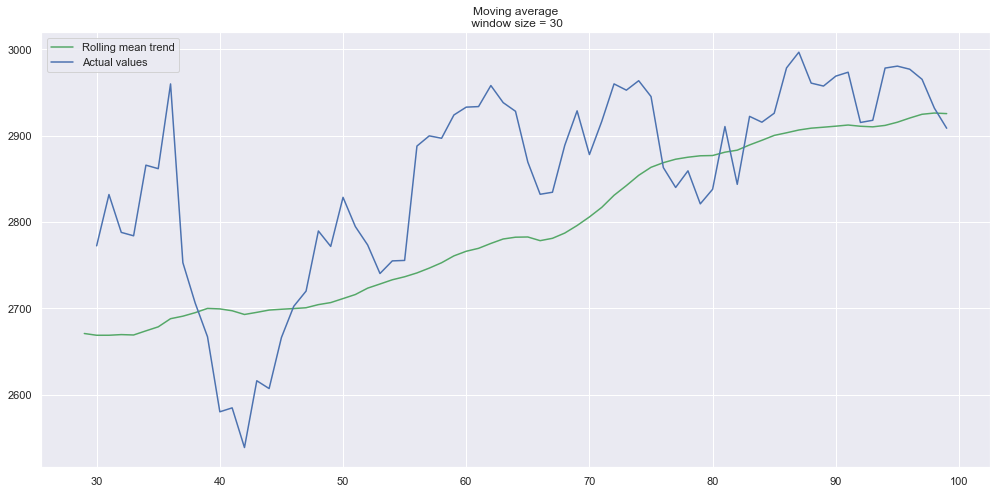

In [6]:
#Smooth by the previous month (30 days)
plot_moving_average(GOOGL['4. close'], 30)

In [93]:
GOOGL['4. close'].rolling(window=30).mean().isnull().sum()

29

In [78]:
mean_squared_error(
    GOOGL['4. close'].rolling(window=30).mean()[-71:], 
    GOOGL['4. close'][-71:])

9822.485420777784

From the graph above, we can see that moving the average on a monthly basis smoothens out the actual price values too much, such that the model does not follow the shape of the actual price values. The MSE of this model is also 9822.5, about three times the MSE of Weekly Moving Average, as such we believe this is not a good model to use

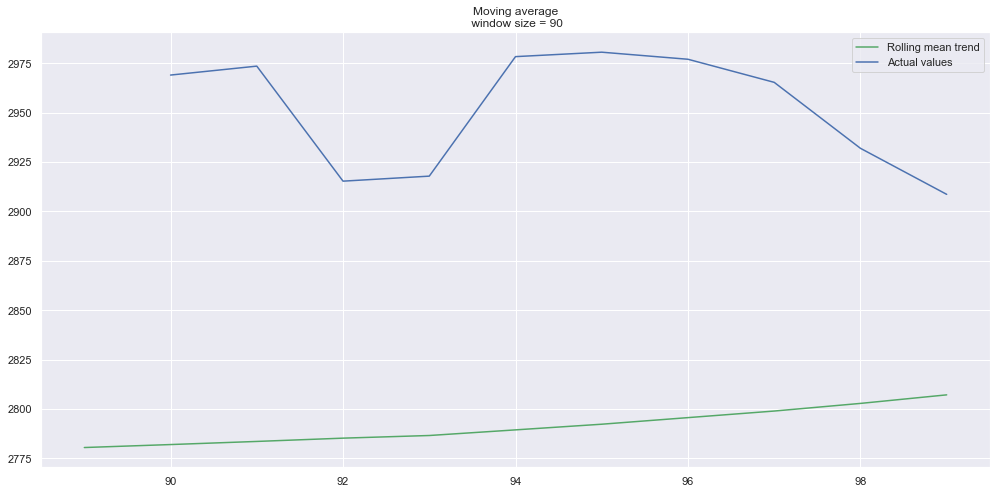

In [22]:
#Smooth by previous quarter (90 days)
plot_moving_average(GOOGL['4. close'], 90)

In [91]:
GOOGL['4. close'].rolling(window=90).mean().isnull().sum()

89

In [92]:
mean_squared_error(
    GOOGL['4. close'].rolling(window=90).mean()[-11:], 
    GOOGL['4. close'][-11:])

26851.471962276046

From the above, we can see that moving the average by the previous quarter smoothens out the price values far too much, such that the model is very far from the actual price values. The MSE is 26851.5 which is nearly nine times the value of the MSE weekly average, as such we believe this is a terrible model and should not be used

### Model 3. Exponential Smoothing

$y = \alpha x_t + (1 - \alpha)y_{t-1}, t > 0$

In [4]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [5]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

Like moving average, exponential smoothing also filters out the noise from short term fluctuations. However exponential smoothing assigns exponentially decreasing weights as a data point gets older, this means that an older data point has less weight to the model than the newest data point. The alpha parameters dictate how important the current data point is for the model. </p>

The alpha parameter can be between 0 and 1 inclusive. The closer alpha is to 1 the more similar the model will be to the actual prices and the lower the MSE. However, if the alpha is too close to 1 the model will be too similar to the actual prices, and hence no "noise filtering" would be done

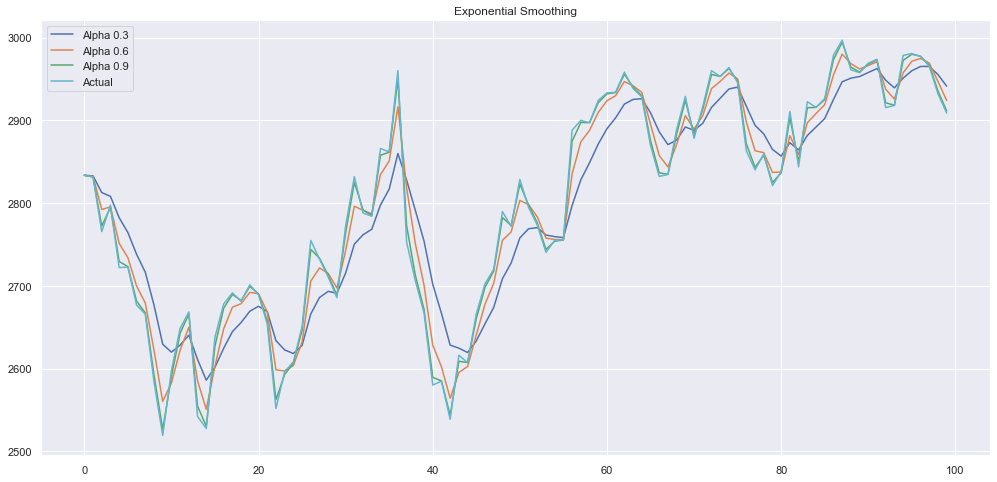

In [75]:
plot_exponential_smoothing(GOOGL['4. close'], [0.3,0.6,0.9])

From the plot above we can see that the alpha 0.3 model may be too far away from the actual prices, while the alplha 0.9 is actually too similar with the actual prices as it is hard to differentiate the 0.9 alpha model and the actual prices. </p>

However for the 0.6 model it is still close to the actual prices, but can still be easily distinguished from the actual prices

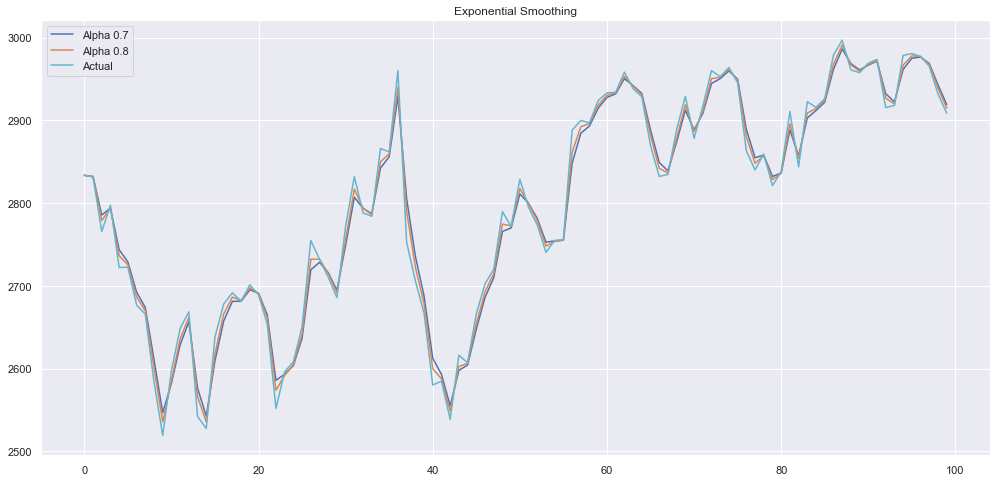

In [85]:
plot_exponential_smoothing(GOOGL['4. close'], [0.7,0.8])

In [82]:
mean_squared_error(
    exponential_smoothing(GOOGL['4. close'], 0.7)[-100:], 
    GOOGL['4. close'][-100:])

267.1794734035934

We see that the 0.8 alpha model can be distinguished easier compared to the 0.9 model, however we believe that it is still too close to the actual prices, such that not enough "noise filtering" is achieved. </p>

As such, we have decided that the 0.7 alpha model would be the most optimal model as it follows the actual prices very well but is far enough from it such that there is enough noise filtering. The MSE for the 0.7 alpha model is also very low 267.2 which is much lower than the MSE of the weekly moving average model. As such, we believe the 0.7 alpha model is very good and should be used

### Model 4. Double Exponential Smoothing

Double Exponential Smoothing is used when there is a trend in the time series. In that case, . 

$y = \alpha x_t + (1 - \alpha)(y_{t-1} + b_{t-1})$

$b_t = \beta (y_t - y_{t-1}) + (1 - \beta)b_{t-1}$

In [3]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result



In [4]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

From the simple exponential smoothing, we know that the alpha should be 0.7, and the beta is something that we need to observe and optimmize.

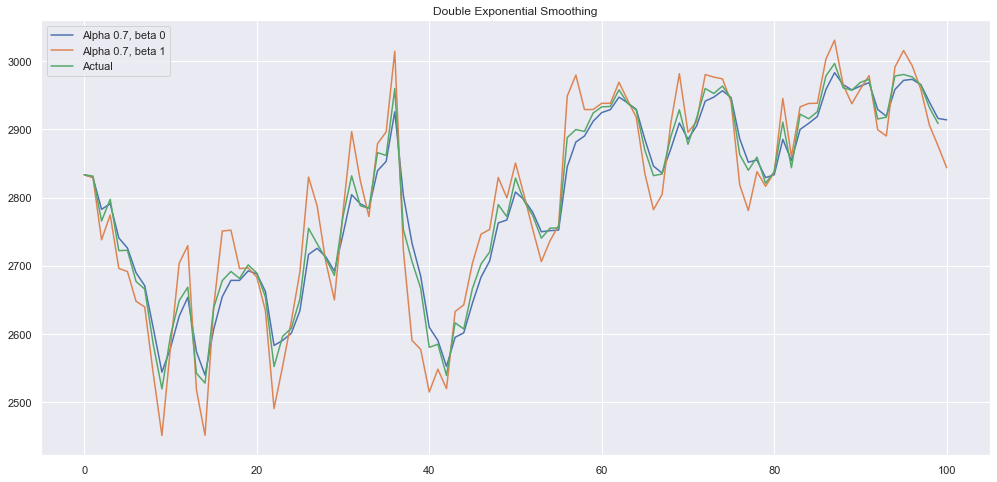

In [53]:
plot_double_exponential_smoothing(GOOGL['4. close'], alphas=[0.7], betas=[0,1])

Beta can range from 0 to 1 inclusive, and we can see that if the beta is at 1, the model moves further away from the actual prices

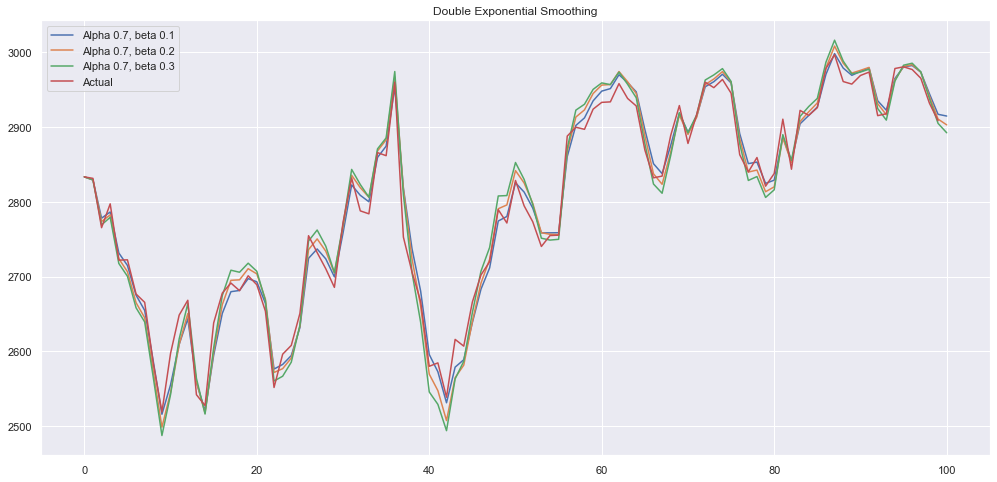

In [54]:
plot_double_exponential_smoothing(GOOGL['4. close'], alphas=[0.7], betas=[0.1,0.2,0.3])

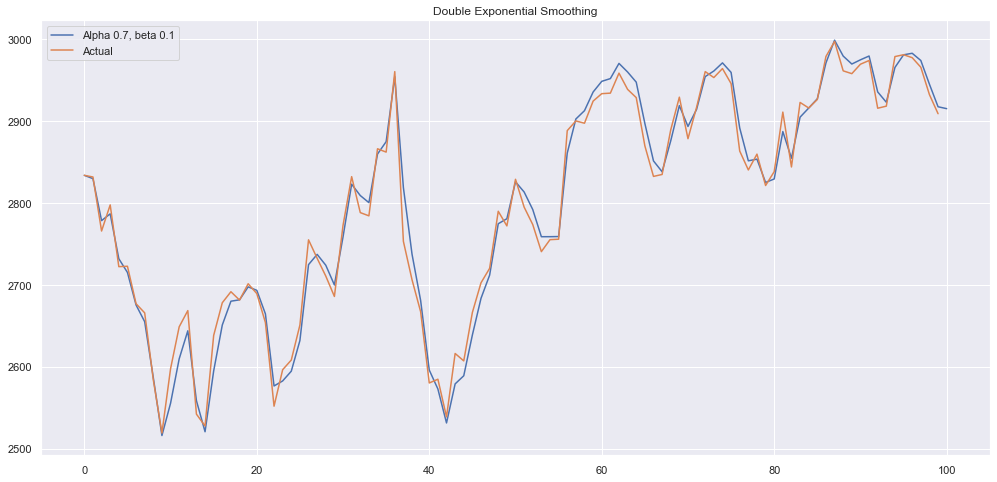

In [58]:
plot_double_exponential_smoothing(GOOGL['4. close'], alphas=[0.7], betas=[0.1])

In [62]:
mean_squared_error(
    double_exponential_smoothing(GOOGL['4. close'], 0.7, 0.1)[-100:], 
    GOOGL['4. close'][-100:])

1614.5599650705935

From above we can see the affect of different betas in a 0.7 alpha model. We see that beta tries to smoothen out any trends in the time series. resulting in a larger differences between the model and the actual prices, hence leading to higher MSE. A beta of 0.1 is enough for this data set as seen from the graph above and the MSE of 1614.6 </p>

the 0.1 beta gives the least change from the the actual price while still smoothening out any trends. There is a large change from the MSE of just the 0.7 alpha model (267.1) and the one with beta 0.1 (1614.6), However the beta 0.1 model is still lower than the weekly moving average MSE. As a result we can conclude that sufficient trend smoothening has taken place, and this model can be used.